# 頻度主義からベイズ統計へ

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from ipywidgets import interact
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os, sys, re
from pathlib import Path

pj_dir = Path(os.getcwd()).parent
data_dir = pj_dir/'data'

from matplotlib import pyplot as plt
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats

In [2]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)

# 例題
ABテスト

In [3]:
visit_a = 1300
visit_b = 1275

cv_a = 120
cv_b = 125

In [4]:
df = pd.DataFrame([[cv_a, visit_a],[cv_b, visit_b]], columns=['cv', 'visit'], index=['a', 'b'])
display(df)

,cv,visit
a,120,1300
b,125,1275


In [5]:
cvr_a = cv_a / visit_a
cvr_b = cv_b / visit_b

print(f"cvr_a: {cvr_a:.2%}")
print(f"cvr_b: {cvr_b:.2%}")

cvr_a: 9.23%
cvr_b: 9.80%


### カイ二乗検定

In [6]:
g, p, dof, expctd = stats.chi2_contingency([[cv_a, visit_a-cv_a], [cv_b, visit_b-cv_b]])
print(f"p-value: {p:.2f}")

p-value: 0.67


### t検定
- http://www.turbare.net/transl/scipy-lecture-notes/packages/statistics/index.html
- [A/Bテストに用いられれる統計的検定手法（ロジック）のまとめ＆比較 | RCO Ad-Tech Lab Blog](https://www.rco.recruit.co.jp/career/engineer/blog/ab-test-logic/)
- [5分でわからない統計的検定 - 唯物是真 @Scaled_Wurm](http://sucrose.hatenablog.com/entry/2016/03/12/233659)

In [7]:
stats.ttest_ind?

In [8]:
a = np.concatenate( [np.ones(cv_a), np.zeros(visit_a-cv_a)])
b = np.concatenate( [np.ones(cv_b), np.zeros(visit_b-cv_b)])
s, p = stats.ttest_ind(a, b, equal_var=True)
print(f"p-value: {p:.2f}")

p-value: 0.62


ちなみにequal_var=Falseの時、等分散性を仮定しないWelchのt検定

In [9]:
def frequentism(visit_a, visit_b, cvr_a, cvr_b):
    cv_a = int(visit_a * cvr_a )
    cv_b = int(visit_b * cvr_b)
    df = pd.DataFrame([[cv_a, visit_a, cvr_a],[cv_b, visit_b, cvr_b]], columns=['cv', 'visit', 'cvr'], index=['a', 'b']).round(2)
    display(df)
    
    g, p, dof, expctd = stats.chi2_contingency([[cv_a, visit_a-cv_a], [cv_b, visit_b-cv_b]])
    print(f"X2 p-value: {p:.2f}")
    
    a = np.concatenate( [np.ones(cv_a), np.zeros(visit_a-cv_a)])
    b = np.concatenate( [np.ones(cv_b), np.zeros(visit_b-cv_b)])
    s, p = stats.ttest_ind(a, b, equal_var=True)
    print(f"t-test p-value: {p:.2f}")

In [10]:
visit_a = 1300
visit_b = 1275
cvr_a = .12
cvr_b = .11

frequentism(visit_a, visit_b, cvr_a, cvr_b)

,cv,visit,cvr
a,156,1300,0.12
b,140,1275,0.11


X2 p-value: 0.45
t-test p-value: 0.42


In [11]:
interact(frequentism, visit_a=(0,3000, 1), visit_b=(0,3000, 1), cvr_a=(0.01,1, 0.01), cvr_b=(0.01,1, 0.01))

interactive(children=(IntSlider(value=1500, description='visit_a', max=3000), IntSlider(value=1500, descriptio…

<function __main__.frequentism(visit_a, visit_b, cvr_a, cvr_b)>

## 頻度主義的仮説検定

[TAKENAKA's Web Page: 有意性検定の無意味さ](http://takenaka-akio.org/etc/stat_test/index.html)

> 統計学的仮説検定は，
1. ほんとに示したいこととは反対のことを帰無仮説として考える．
2. データを集める．
3. データと帰無仮説からp 値を計算する．
4. p 値にもとづいて帰無仮説を評価する

> ここに登場するp 値は，
- 得られたデータが偶然の結果である可能性を示す．
- 1 - p が，得られたデータの確かさ（同じ実験や調査をしたときに同様の結果が得られるか）を示す．
- 帰無仮説が正しい可能性を示す．   

> などと解釈されるが，これはどれも間違い．

> 正しくは， 「帰無仮説が正しく，かつ想定する統計モデルが正しく，データがランダムにとられている場合に，**観測データ＋'もっと極端な'データが得られる確率**」を示す．

# Bayse

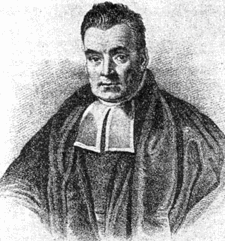

In [12]:
Image(filename=str(pj_dir/'images/bayse.gif'))

### 頻度主義とベイズは何が違うか
- パラメータへの姿勢
    - 頻度主義は真のパラメーターが唯一つあると考える
    - ベイズはパラメータを確率変数として考える
- 事前分布の考え方
    - 頻度主義は事前分布(主観的分布)を一切認めない
    - ベイズは事前分布(主観的分布)を利用して問題を簡単にする
- 計算量の違い
    - 頻度主義的アプローチはコンピュータがなくても解くことができる
    - ベイズ的アプローチはときに人力では難しい計算量を要求する

## ベイズの定理

$$
p(\theta\ |\ x) = \frac{p(x\ | \ \theta)\ p(\theta)}{p(x)}
$$

ABテストでは
- x: log
- $\theta $: CVR
- $ p(\theta) $ あるCVRになる確率(真の値は神しか知り得ない)
- $ p(\theta\ |\ x) $: あるlog(x)が得られた時のCVRの取りうる確率(密度関数)　 (知りたい)
- $ p(x) $ は定数なので無視してよい(とだけ思ってください)

# BaysianABTest
参考になるサイト
- [【ベイズ推定って結局何なの？】 - HELLO CYBERNETICS](http://s0sem0y.hatenablog.com/entry/2017/07/21/051219)
- [pythonでベイジアンA/Bテスト(RCT)を行ってみた - 猫になりたい](http://blog.neko-ni-naritai.com/entry/2018/01/06/180518)
- [心理学者のためのベイズ統計入門](https://www.slideshare.net/simizu706/ss-57721033)

## ベイズ推定
ベイズ推定を行う主だった方法は3つある。
- 共役事前分布
- MCMC
- 変分近似

変分近似は自分がまだ理解できていないので共役事前分布を使った方法とMCMCについて説明する

### 共役事前分布

## CVする確率を二項分布、CVRをベータ分布に従うと仮定する

二項分布: n回のvisitのうち、cvした回数がxである確率。$ {}_n C _x $は定数(なので無視する)

$$
P(x\ |\ \theta(, n)) = {}_n C _x \theta^x (1-\theta)^{n-x}
$$

ベータ分布: $ [0, 1] $ の値を取る分布。二項分布の**共役事前分布** $ B $ は正規化定数(なので無視する)

$$
P(\theta\ |\ \alpha, \beta)\ =\ \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)} 
$$

参考リンク
- [共役事前分布の意味といくつかの例 - 具体例で学ぶ数学](https://mathwords.net/kyoyakujizen)

それぞれどんな分布か

In [13]:
def display_binom(theta, n):
    dist = stats.binom(n, theta)
    x = np.linspace(0, n, n+1)
    plt.scatter(x, dist.pmf(x))
    print(f"binom{dist.args}")

In [14]:
interact(display_binom, theta=(0.01, 1, 0.01), n=(1, 100, 1))

interactive(children=(FloatSlider(value=0.5, description='theta', max=1.0, min=0.01, step=0.01), IntSlider(val…

<function __main__.display_binom(theta, n)>

In [15]:
def display_beta(alpha, beta):
    x = np.linspace(0, 1, 501)
    dist = stats.beta(alpha, beta)
    datas = dist.pdf(x)
    print(f"beta{dist.args}")
    plt.plot(x, datas)
    plt.xlim(0, 1)
    plt.fill_between(x, datas, 0, alpha=.5)

In [16]:
interact(display_beta, alpha=(1, 100, 1), beta=(1, 100, 1))

interactive(children=(IntSlider(value=50, description='alpha', min=1), IntSlider(value=50, description='beta',…

<function __main__.display_beta(alpha, beta)>

これを先程のベイズの定理に当てはめたい。

$$
p(\theta\ |\ x) = \frac{p(x\ | \ \theta)\ p(\theta)}{p(x)}
$$

ここで、 $ P(\theta) $ は私たちにはわからないの**適当に**決める。具体的には $ \alpha = 1, \beta = 1 $の一様分布とする

$$
P(\theta)\ =\ \theta^0 (1-\theta)^0
$$

先程の式に当てはめると

$$
\begin{eqnarray}
p(\theta\ |\ x) & \propto & \theta^x (1-\theta)^{n-x}\theta^0 (1-\theta)^0 \\
& \propto & \theta^{0+x} (1-\theta)^{0+n-x} \\
& \propto & beta(\alpha + x, \beta + n -x)\ \  (= \ \frac{\theta^{\alpha-1 + x}\ (1-\theta)^{\beta-1 + n -x}}{B(\alpha, \beta)}  )
\end{eqnarray}
$$

In [17]:
def display_dist(dist_a, dist_b, xlim=None):
    x = np.linspace(0, 1, 501)
    y_a = dist_a.pdf(x)
    y_b = dist_b.pdf(x)
    plt.plot(x, y_a, label='a')
    plt.fill_between(x, 0, y_a, alpha=.2)
    plt.plot(x, y_b, label='b')
    plt.fill_between(x, 0, y_b, alpha=.2)
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()

In [18]:
def baysian_update(n, x, prior):
    print(f"prior beta:{prior.args}")
    alpha, beta = prior.args
    posterior = stats.beta(alpha+x, beta+n-x)
    print(f"posterior beta:{posterior.args}")    
    return posterior

最初の例題

In [19]:
visit_a = 1300
visit_b = 1275

cv_a = 120
cv_b = 125

cvr_a = cv_a / visit_a
cvr_b = cv_b / visit_b

print(f"cvr_a: {cvr_a:.2%}")
print(f"cvr_b: {cvr_b:.2%}")

cvr_a: 9.23%
cvr_b: 9.80%


事前分布を一様分布

In [20]:
prior_a = stats.beta(1, 1)
prior_b = stats.beta(1, 1)

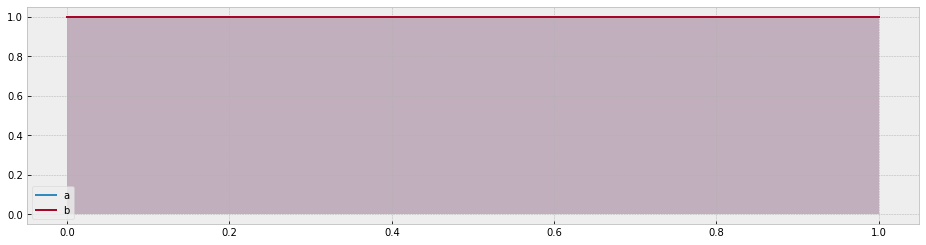

In [21]:
display_dist(prior_a, prior_b)

ベイズ更新

In [22]:
posterior_a = baysian_update(n=visit_a, x=cv_a, prior=prior_a)
posterior_b = baysian_update(n=visit_b, x=cv_b, prior=prior_b)

prior beta:(1, 1)
posterior beta:(121, 1181)
prior beta:(1, 1)
posterior beta:(126, 1151)


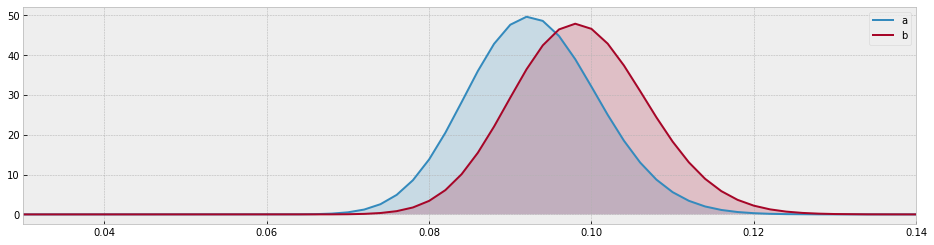

In [23]:
display_dist(posterior_a, posterior_b, xlim=(0.03, 0.14))

bがaより高い確率

Probability that  b is higher than a:  0.68


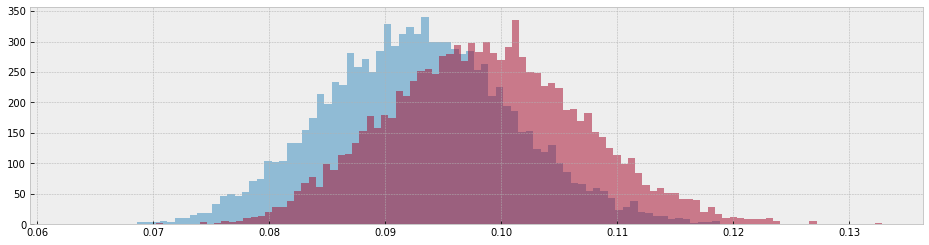

In [24]:
n_sample = 10000

samples_a = posterior_a.rvs(n_sample)
samples_b = posterior_b.rvs(n_sample)

a = plt.hist(samples_a, bins=100, alpha=.5)
a = plt.hist(samples_b, bins=100, alpha=.5)

print(f"Probability that  b is higher than a:  {(samples_a < samples_b).mean():.2f}")

更に同じログが残されたとしてベイズ更新

In [25]:
posterior_a = baysian_update(n=visit_a, x=cv_a, prior=posterior_a)
posterior_b = baysian_update(n=visit_b, x=cv_b, prior=posterior_b)

prior beta:(121, 1181)
posterior beta:(241, 2361)
prior beta:(126, 1151)
posterior beta:(251, 2301)


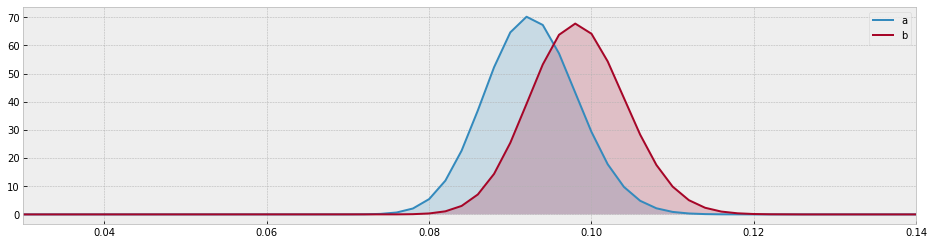

In [26]:
display_dist(posterior_a, posterior_b, xlim=(0.03, 0.14))

Probability that  b is higher than a:  0.76


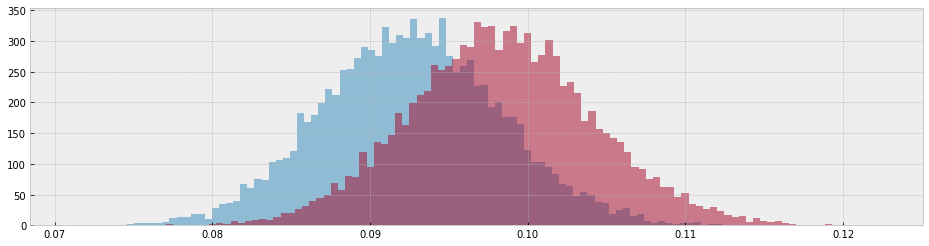

In [27]:
n_sample = 10000

samples_a = posterior_a.rvs(n_sample)
samples_b = posterior_b.rvs(n_sample)

a = plt.hist(samples_a, bins=100, alpha=.5)
a = plt.hist(samples_b, bins=100, alpha=.5)

print(f"Probability that  b is higher than a:  {(samples_a < samples_b).mean():.2f}")

In [28]:
def bayse_inference(visit_a, visit_b, cvr_a, cvr_b):
    cv_a = int(visit_a * cvr_a )
    cv_b = int(visit_b * cvr_b)

    prior_a = stats.beta(1, 1)
    prior_b = stats.beta(1, 1)
    posterior_a = baysian_update(n=visit_a, x=cv_a, prior=prior_a)
    posterior_b = baysian_update(n=visit_b, x=cv_b, prior=prior_b)
    
    n_sample = 10000

    samples_a = posterior_a.rvs(n_sample)
    samples_b = posterior_b.rvs(n_sample)

    a = plt.hist(samples_a, bins=100, alpha=.5)
    a = plt.hist(samples_b, bins=100, alpha=.5)

    print(f"Probability that b is higher than a:  {(samples_a < samples_b).mean():.2%}")
    print(f"Probability that a is higher than b:  {(samples_a > samples_b).mean():.2%}")

In [29]:
interact(bayse_inference, visit_a=(0,3000, 1), visit_b=(0,3000, 1), cvr_a=(0.01,1, 0.01), cvr_b=(0.01,1, 0.01))

interactive(children=(IntSlider(value=1500, description='visit_a', max=3000), IntSlider(value=1500, descriptio…

<function __main__.bayse_inference(visit_a, visit_b, cvr_a, cvr_b)>

## 現在の検定との比較

In [30]:
def compare(visit_a, visit_b, cvr_a, cvr_b):
    print("--"*30 + " frequentism " + "--"*30 )
    frequentism(visit_a, visit_b, cvr_a, cvr_b)
    print("--"*30 + " bayse " + "--"*30 )
    bayse_inference(visit_a, visit_b, cvr_a, cvr_b)

In [31]:
interact(compare, visit_a=(0,3000, 1), visit_b=(0,3000, 1), cvr_a=(0.01,1, 0.01), cvr_b=(0.01,1, 0.01))

interactive(children=(IntSlider(value=1500, description='visit_a', max=3000), IntSlider(value=1500, descriptio…

<function __main__.compare(visit_a, visit_b, cvr_a, cvr_b)>

## BaysianBandit
この延長線上として簡単に多腕バンディットも実装することができる

In [32]:
class Bandits():
    def __init__(self, p: np.array):
        self.p = p
        self.optimal = np.argmax(p)
    
    def pull(self, i):
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

In [33]:
class BaysianStrategy():
    def __init__(self, bandits):
        self.bandits = bandits
        
        n_b = len(bandits)
        print("Number of bandits: ", n_b)
        
        self.wins = np.zeros(n_b)
        self.trials = np.zeros(n_b)
        self.dists = stats.beta(*np.ones((2, n_b)))
                
        self.N = 0
        self.choices = []
        self.results = []
        
    def sample_bandits(self, n=1, debug=False):
        print("Number of this trials: ", n)
        self.N += n
        
        for k in range(n):
            # Sample from the bandit's priors, and select the largest one
            samples = self.dists.rvs()
            choice = np.argmax(samples)

            # Try
            result = self.bandits.pull(choice)
            
            if debug:
                print("Samples from current beta dist: ", samples)
                print("Selected bandit: ", choice)
                print("Result: ", result)
                
            # Update priors
            self.dists.args[0][choice] += result
            self.dists.args[1][choice] += 1 - result
            
            # Save result
            self.wins[choice] += result
            self.trials[choice] += 1
            self.results.append(result)
            self.choices.append(choice)
            
        if debug:
            print("results: ", self.results)
            print("choices: ", self.choices)
            print("Number of all trials: ", self.N)   

    def show_status(self, hidden_prob=None):
        self.print_dist()
        self.plot_dist(hidden_prob)  
        
    def print_dist(self):
        for i, (alpha, beta) in enumerate(map(list, zip(*self.dists.args))):
            print(f"{i} bandit : beta(alpha={alpha}, beta={beta}")

            
    def plot_dist(self, hidden_prob=None):
        tmp = np.linspace(0, 1, 201)
        x = np.array([tmp, tmp, tmp]).T
        y = self.dists.pdf(x)
        p = plt.plot(x, y, alpha=.3)
        for i, y_i in enumerate(y.T):
            plt.fill_between(tmp, y_i, 0, alpha=.3, color=f"C{i}")
        
        if hidden_prob is not None:
            for i, pr in enumerate(hidden_prob):
                plt.vlines(pr, 0, self.dists.pdf(pr)[i], color=f"C{i}", linestyles = "--")
        plt.legend(p, [0, 1, 2])
        plt.title(f"Distribution After {self.N} trial")

Number of bandits:  3
0 bandit : beta(alpha=1.0, beta=1.0
1 bandit : beta(alpha=1.0, beta=1.0
2 bandit : beta(alpha=1.0, beta=1.0


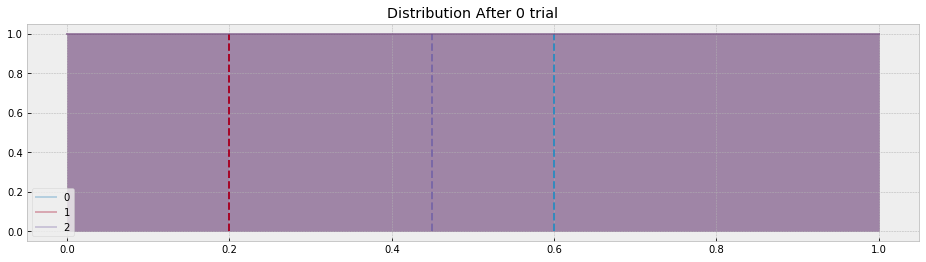

In [34]:
hidden_prob = np.array([0.6, 0.2, 0.45])
bandits = Bandits(hidden_prob)
bayesian_strat = BaysianStrategy(bandits)
bayesian_strat.show_status(hidden_prob)

Number of this trials:  10
0 bandit : beta(alpha=4.0, beta=4.0
1 bandit : beta(alpha=2.0, beta=3.0
2 bandit : beta(alpha=1.0, beta=2.0


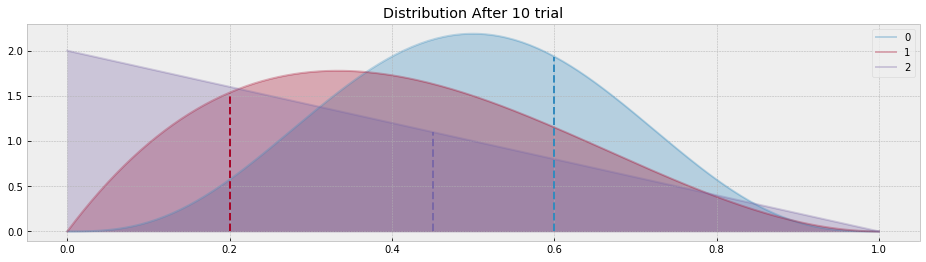

In [35]:
bayesian_strat.sample_bandits(10)
bayesian_strat.show_status(hidden_prob)

Number of this trials:  100
0 bandit : beta(alpha=58.0, beta=37.0
1 bandit : beta(alpha=3.0, beta=9.0
2 bandit : beta(alpha=3.0, beta=6.0


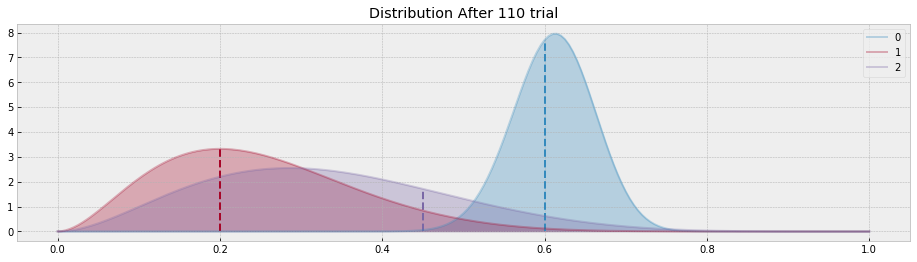

In [36]:
bayesian_strat.sample_bandits(100)
bayesian_strat.show_status(hidden_prob)

Number of this trials:  1000
0 bandit : beta(alpha=623.0, beta=433.0
1 bandit : beta(alpha=3.0, beta=14.0
2 bandit : beta(alpha=19.0, beta=24.0


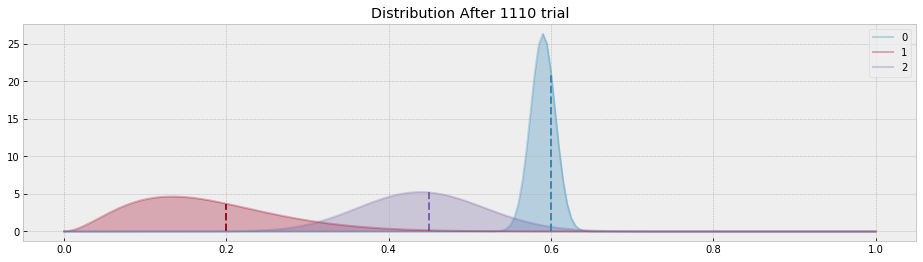

In [37]:
bayesian_strat.sample_bandits(1000)
bayesian_strat.show_status(hidden_prob)

Number of this trials:  5000
0 bandit : beta(alpha=3645.0, beta=2377.0
1 bandit : beta(alpha=3.0, beta=14.0
2 bandit : beta(alpha=35.0, beta=42.0


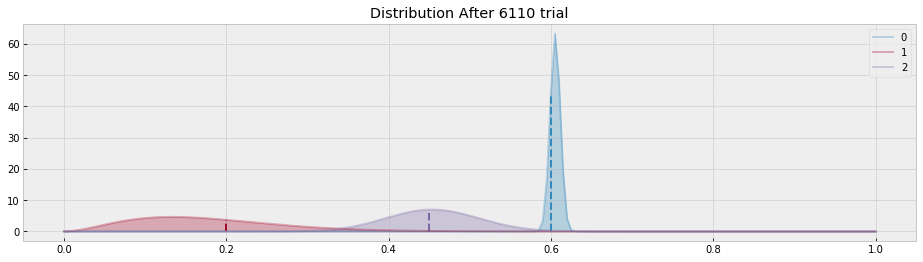

In [38]:
bayesian_strat.sample_bandits(5000)
bayesian_strat.show_status(hidden_prob)

## MCMCを用いた推定

In [39]:
import pymc3 as pm

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


もう一度例題

In [40]:
visit_a = 1300
visit_b = 1275

cv_a = 120
cv_b = 125

cvr_a = cv_a / visit_a
cvr_b = cv_b / visit_b

print(f"cvr_a: {cvr_a:.2%}")
print(f"cvr_b: {cvr_b:.2%}")

cvr_a: 9.23%
cvr_b: 9.80%


In [41]:
obs_a = np.concatenate([ np.ones(cv_a), np.zeros(visit_a - cv_a)])
obs_b = np.concatenate([ np.ones(cv_b), np.zeros(visit_b - cv_b)])

In [42]:
with pm.Model() as model:
    p_a = pm.Uniform("p_a", 0, 1)
    p_b = pm.Uniform("p_b", 0, 1)
    delta = pm.Deterministic("delta", p_a - p_b)
    
    obs_a = pm.Bernoulli("obs_a", p_a, observed=obs_a)
    obs_a = pm.Bernoulli("obs_b", p_b, observed=obs_b)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_b_interval__]
>Metropolis: [p_a_interval__]
100%|██████████| 20500/20500 [00:05<00:00, 3674.61it/s]
The number of effective samples is smaller than 25% for some parameters.


In [43]:
burned_trace = trace[1000:]

<Figure size 1152x864 with 0 Axes>

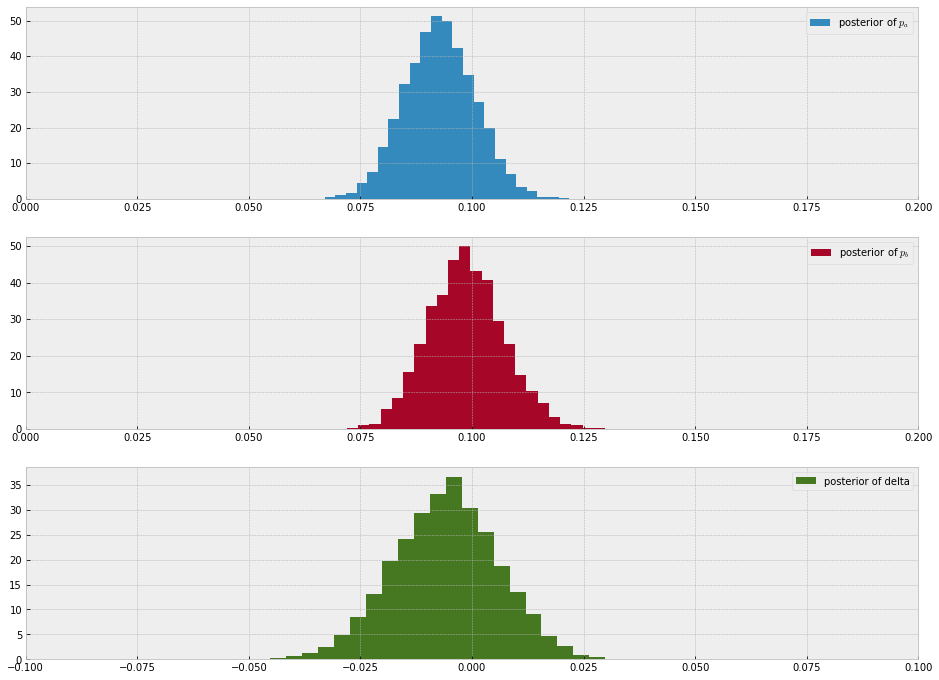

In [44]:
plt.figure(figsize=(16, 12))

ax = plt.subplot(3, 1, 1)
d = ax.set_xlim(0, .2)
d = ax.hist(burned_trace['p_a'], bins=25, density=True, color="C0", label="posterior of $p_a$")
d = ax.legend()

ax = plt.subplot(3, 1, 2)
d = ax.set_xlim(0, .2)
d = ax.hist(burned_trace['p_b'], bins=25, density=True, color="C1", label="posterior of $p_b$")
d = ax.legend()

ax = plt.subplot(3, 1, 3)
d = ax.set_xlim(-0.1, .1)
d = ax.hist(burned_trace['delta'], bins=25, density=True, color="C3", label="posterior of delta")
d = ax.legend()

In [45]:
print(f"Probability site a is higher than b: { (burned_trace['delta'] > 0).mean():.2%}")
print(f"Probability site a is lower than b: { (burned_trace['delta'] < 0).mean():.2%}")

Probability site a is higher than b: 30.64%
Probability site a is lower than b: 69.36%


### なぜMCMCを使うか
- 常に共役事前分布が見つかるとは限らない
- 使う分布が複雑だったり階層モデルになったときに問題を解く難易度が跳ね上がる